# Navigation using Reinforcement Learning

---

This project creates an agent to navigate (and collect bananas!) in a large, square world.

### 1. Start the Environment

**Unity Machine Learning Agents (ML-Agents)** is an open-source Unity plugin that enables games and simulations to serve as environments for training intelligent agents. It has myriads of environments up for a challenge, and in which the environment we will be solving during this project is **Banana Collector**.
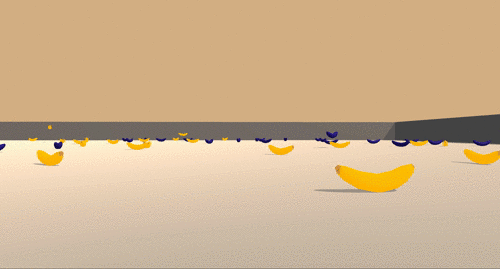

A reward of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana. Thus, the goal is to collect as many yellow bananas as possible while avoiding blue bananas.

Let's start by installing all the required dependencies:

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is provided and can be accessed at the file path below.

In [2]:
#export
from unityagents import UnityEnvironment
import numpy as np

# Load the environment
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


The state space has `NumberOfAgents`x`37` dimensions and contains each agent's velocity, along with ray-based perception of objects around the agent's forward direction. Since we have only single agent navigating the world, our `S`, state space, is single vector of length 37. 

Four discrete actions are available, corresponding to:
- `0` - move forward.
- `1` - move backward.
- `2` - turn left.
- `3` - turn right.

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents, representing the agent. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
#export
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(brain_name)

BananaBrain


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
state = np.array(state)
print('States are represented by:', state.dtype)
print('States have shape:', state.shape)

Number of agents: 1
Number of actions: 4
States are represented by: float64
States have shape: (37,)


### 3. Take Random Actions in the Environment

Lets take look at using the Python API to control the agent and receive feedback from the environment. We will run a single episode with a RandomAgent who takes actions randomly.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)       # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


### 4. DQN Agent Solver

The RL learning algorithm that we will use to solve this environment is the fabled DQN algorithm. This is the breakthrough that fueled the current deep RL momentum. DQN demonstrated the capability of RL by achieving human level control of Atari-2600 games directly from the pixels as described in their paper published on Nature[https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning]. 

![image.png](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fnature14236/MediaObjects/41586_2015_Article_BFnature14236_Fig1_HTML.jpg)

Before DQN times, the Deep RL was notoriously unstable during training. In the paper, they presented two novel ideas that effectively, albeit not perfectly, deals with this probelm. They were:

- Experience Replay - Storing situations encountered, actions taken, and reward received, then randomly visit them to learn.
- Target Network - Keeping seperate network that periodically updates to avoid chasing after moving target.

These concepts are what makes DQN agent.

We will use the implementation of basic DQN agent to solve the environment without any convolution layers. The DQN agent solves the environment under 500 episodes. Although it is basic DQN agent, it is empirically demonstrated to be able to solve the environment within 500 episodes.

In [6]:
#export
import torch
from collections import deque
from dqn_agent import Agent

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

Define the environment variables

In [8]:
#export
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

Q-Learning algorithm that uses deep neural network agents

In [9]:
#export
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, agent_seed = 0):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        agent_seed (int): random seed for agent's weights
    """
    agent = Agent(state_size=state_size, action_size=action_size, seed=agent_seed)   #Initialize the Agent
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):
            
            action = agent.act(state, eps)                 # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]     
            
            agent.step(state, action, reward, next_state, done)  #Update the Agent
            
            state = next_state
            score += reward
            if done:
                break 
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
        #environment is solved
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth') #Save the model weights
            break
            
    return scores

Let's test the DQNetwork defined above and plot the score

Episode 100	Average Score: 1.09
Episode 200	Average Score: 4.46
Episode 300	Average Score: 8.25
Episode 400	Average Score: 10.91
Episode 500	Average Score: 12.89
Episode 518	Average Score: 13.02
Environment solved in 418 episodes!	Average Score: 13.02


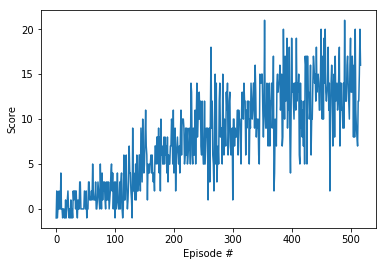

In [10]:
scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Close the environment after training.

In [11]:
env.close()

#### Hyperparaments
Note that the hyper parameters used for the training was:
    - n_episodes = 2000
        Train for total of 2000 episodes until the environment is solved
    - max_t = 1000 
        Maximum of 1000 timesteps per episode
    - eps_start = 1.0
        Epsilon of Greedy-epsilon policy starts at value 1.0
    - eps_end = 0.01   
        Minimum epsilon value after decay
    - eps_decay = 0.995
        Epsilon decay rate

#### Neural network inside the agent

The policy neural network inside the agent is simple shallow network with 3 layers.

    State value -> LinearLayer(37, 64) -> Relu -> LinearLayer(64, 64) -> Relu -> LinearLayer(64, 4) -> Action values

### 5. Command-Line usage parser
The following is parser for the command line interface for the DQN solving the unity environment. 
<b>Not to be executed</b>

In [ ]:
#export
if __name__ == '__main__':
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('--n_episodes', type=int, default=2000)
    parser.add_argument('--max_t', type=int, default=1000)
    parser.add_argument('--eps_start', type=float, default=1.0)
    parser.add_argument('--seed', '-s', type=int, default=0)
    parser.add_argument('--eps_end', type=float, default=0.01)
    parser.add_argument('--eps_decay', type=float, default=0.995)
    args = parser.parse_args()
    

    dqn(n_episodes = args.n_episodes, max_t = args.max_t, eps_start = args.eps_start, \
        eps_end = args.eps_end, eps_decay = args.eps_decay, agent_seed = args.seed)
env.close() 


### 6. Generate script from the notebook
Throughout this notebook you've been seeing cells marked with ```#export```. The script below picks cells that are marked and append them into python script. This is adopted from fast-ai's deep learning course practice.

In [14]:
!python notebook2script.py Report.ipynb

Converted Report.ipynb to nb_Report.py


After running the cell above, `nb_Navigation.py` script should have been generated in your workspace. 

### 7. Run the script from the command-line

In [15]:
!python nb_Report.py

Found path: /data/Banana_Linux_NoVis/Banana.x86_64
Mono path[0] = '/data/Banana_Linux_NoVis/Banana_Data/Managed'
Mono config path = '/data/Banana_Linux_NoVis/Banana_Data/MonoBleedingEdge/etc'
Preloaded 'libgrpc_csharp_ext.x64.so'
Unable to preload the following plugins:
	libgrpc_csharp_ext.x86.so
Logging to /root/.config/unity3d/Unity Technologies/Unity Environment/Player.log
xcb_connection_has_error() returned true
xcb_connection_has_error() returned true
xcb_connection_has_error() returned true
INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Actio

### 8. Conclusions and Future Work

#### Summary

We've just learned to collect yellow bananas in Unity Environment, yay! Our DQN agent proved to be versalite and able to solve the environment during repeated trials. This, by itself, proves that DQN agent is able to solve such continuous control scenarios. 

Now, you can play around with the hyperparameters to make it even more efficient.

### Future work

This was DQN agent introduced by paper, "Human-level control through deep reinforcement learning" in 2015. It was a breakthrough that could play Atari 2600 games from visual input. However, we modified this to work with sensory inputs rather than pixels. Therefore, we can re-add the convolutional layers and modify to observations to screen input to pixel-to-action control. You are encouraged to follow this setup:

- Linux: [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/VisualBanana_Linux.zip)
- Mac OSX: [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/VisualBanana.app.zip)
- Windows (32-bit): [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/VisualBanana_Windows_x86.zip)
- Windows (64-bit): [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/VisualBanana_Windows_x86_64.zip)


Then, place the file in the p1_navigation/ folder in the DRLND GitHub repository, and unzip (or decompress) the file. Next, open Navigation_Pixels.ipynb and follow the instructions to learn how to use the Python API to control the agent.

Moreover, as you've seen on the rewards graph, the rewards during the training spike up and down quite a bit. There was numerous improvements to the DQN following the breakthrough. Consequentially, the most prominent contributions were packed into one by researchers, and it was named Rainbow. These improvements not only make it more stable but even more efficient. You can find the paper at https://arxiv.org/abs/1710.02298.
